In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from scipy.special import inv_boxcox
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sample_data_path = '../../v1_1/data/RIbench/Data/'


In [2]:
params = pd.read_csv('./SpecificationTestSets.csv') # get RIbench test set parameters

params = params[(params.Analyte!='CRP') & (params.Analyte!='LDH')] # don't include CRP
# params = params[params.Analyte!='LDH'] # don't include CRP
params = params[params.fractionPathol==0.50]

# get all the unique component parameters
subset_cols = ['nonp_mu', 'nonp_sigma', 'nonp_lambda', 'left_mu', 'left_sigma', 'right_mu', 'right_sigma', 'bg_max', 'bg_min']
params = params.drop_duplicates(subset=subset_cols)
params = params.reset_index(drop=True)


In [3]:
params.shape[0]


144

2


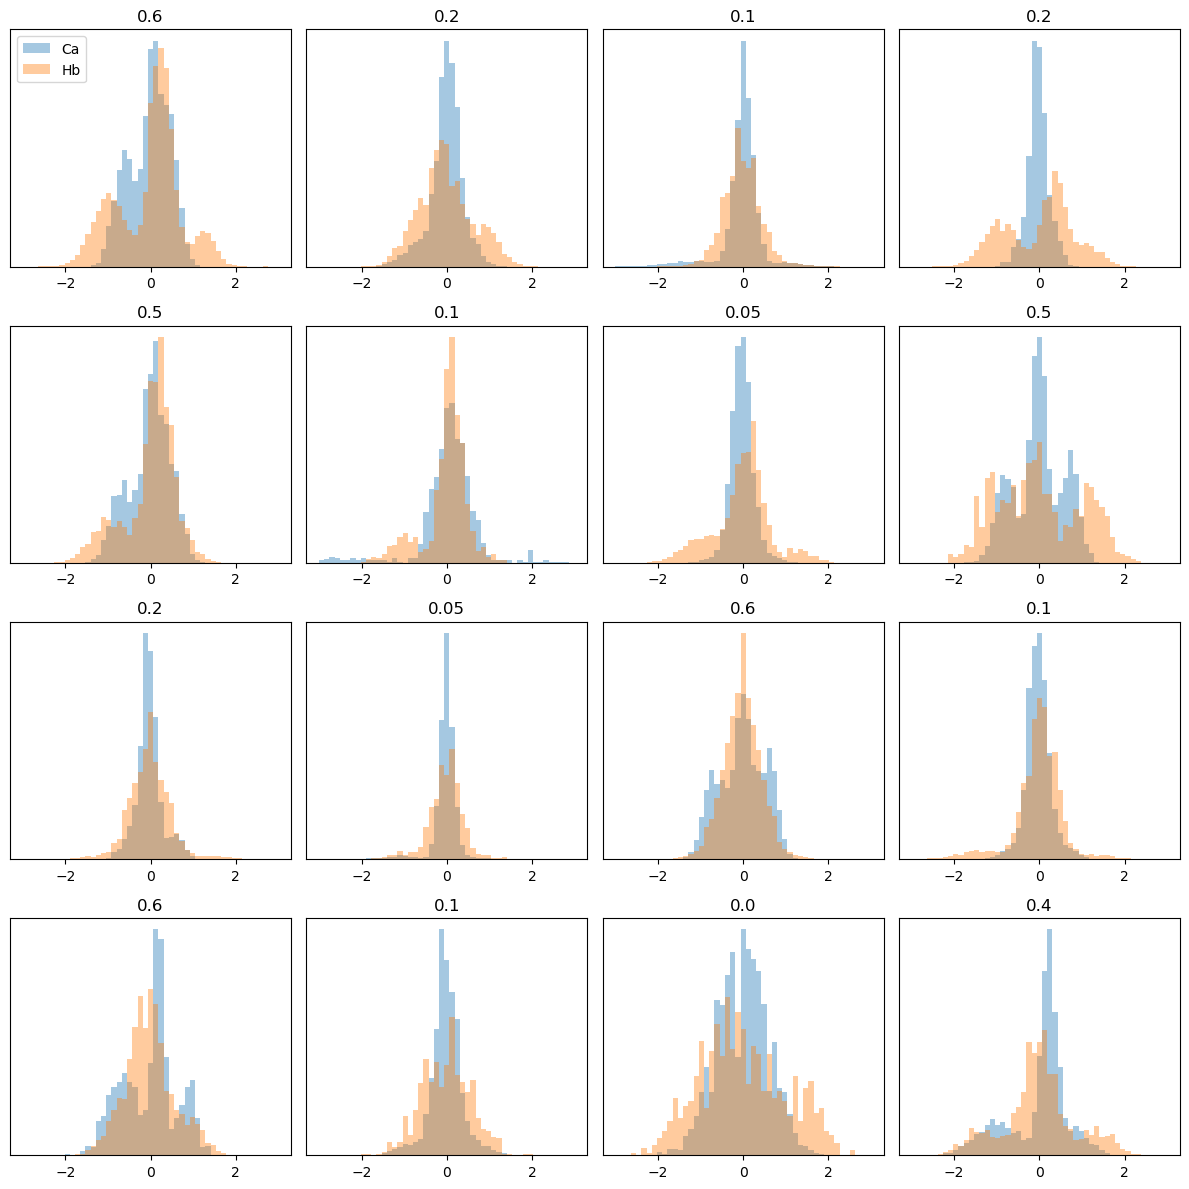

In [4]:
# for checking RIBench analytes

params_all = pd.read_csv('./SpecificationTestSets.csv')

analyte = 'Ca'
nr = 4
nc = 4
plt.figure(figsize=(12,12))
files = os.listdir(sample_data_path+analyte)
for i in range(nr*nc):
    data = pd.read_csv(sample_data_path+analyte+'/'+files[i], header=None).values.astype(float)
    temp_params = params_all[params_all.Index==int(files[i].split('_')[0])]
    data -= data.mean()
    data /= data.std()
    plt.subplot(nr, nc, i+1)
    plt.title(temp_params.fractionPathol.values[0])
    plt.hist(data, np.linspace(-3, 3, 50), density=True, alpha=0.4, label=analyte)
    if i==0:
        plt.legend(loc='upper left')
    plt.yticks([])
plt.tight_layout()
print(temp_params.decimals.values[0])
    
# for checking an analyte
analyte = 'Hb'
if analyte:
    files = os.listdir(sample_data_path+analyte)
    for i in range(nr*nc):
        data = pd.read_csv(sample_data_path+analyte+'/'+files[i], header=None).values.astype(float)
        data -= data.mean()
        data /= data.std()
        plt.subplot(nr, nc, i+1)
        plt.hist(data, np.linspace(-3, 3, 50), density=True, alpha=0.4, label=analyte)
        if i==0:
            plt.legend(loc='upper left')
        plt.yticks([])



In [5]:
# we want to model how the statistics of the 
# mixtures are related to 
# standardized reference components

# since the reference is standardized, it will only depend on skew
# the inv_boxcox lambda will be the only reference parameter fitted to skew

# we will try using the parameters of the highest-skewed non-CRP-analyte (IgE)
# in order to model skew vs lambda


In [6]:
# get the skews of the reference distributions - mean, std, and skew

ref_mean = [] # mean and std used for getting standardized path stats
ref_std = []
ref_pdf = [] # for plotting / checking
ref_zero = [] 
ref_skew = []
x = np.linspace(-10, 10, 200)
for c,i in enumerate(params.iterrows()): # loop unique params
    
    if c%50==0:
        print(c)
    
    i = i[1] # just get columns
    
    data = np.random.normal(i['nonp_mu'], i['nonp_sigma'], 50000) # take a big sample
    data = inv_boxcox(data, i['nonp_lambda']) # transform
    
    ref_mean.append(data.mean()) # take statistics
    ref_std.append(data.std())
    ref_zero.append(-ref_mean[-1]/ref_std[-1]) # this is where 0 is in standardized space: (0-mean)/std
    
    data = (data-data.mean())/data.std() # standardize
    
    ref_skew.append(scipy.stats.skew(data)) # estimate skew

    kde = scipy.stats.gaussian_kde(data) # get KDE for plotting
    ref_pdf.append(kde(x)) # save KDE
    
ref_mean = np.array(ref_mean)
ref_std = np.array(ref_std)
ref_zero = np.array(ref_zero)
ref_skew = np.array(ref_skew)
ref_pdf = np.array(ref_pdf)
analytes = np.array(params.Analyte)
indices = np.array(params.Index)
del data



0
50
100


In [7]:
# now get the standardized pathological statistics

p_mean = []
p_std = []
bg_range = []
for c,i in enumerate(params.iterrows()): # loop unique params
    
    if c%50==0:
        print(c)
    
    i = i[1]
    
    p_mean.append([
        (i['left_mu']-ref_mean[c])/ref_std[c],
        (i['right_mu']-ref_mean[c])/ref_std[c]
    ])
    p_std.append([
        i['left_sigma']/ref_std[c],
        i['right_sigma']/ref_std[c]
    ])
    bg_range.append([
        (i['bg_min']-ref_mean[c])/ref_std[c],
        (i['bg_max']-ref_mean[c])/ref_std[c]
    ])
    
p_mean = np.array(p_mean)
p_std = np.array(p_std)



0
50
100


In [8]:
# get RIbench sample data for plotting / checking
sample_data = []
for i,j in zip(analytes, indices):
    files = os.listdir(sample_data_path+i)
    file = [k for k in files if k.startswith(str(j)+'_')][0]
    sample_data.append(pd.read_csv(sample_data_path+str(i)+'/'+file, header=None).values)
    

In [9]:
sorted(list(set(params.Analyte)))


['AST', 'Ca', 'FT4', 'GGT', 'Hb', 'IgE', 'LACT', 'TSH']

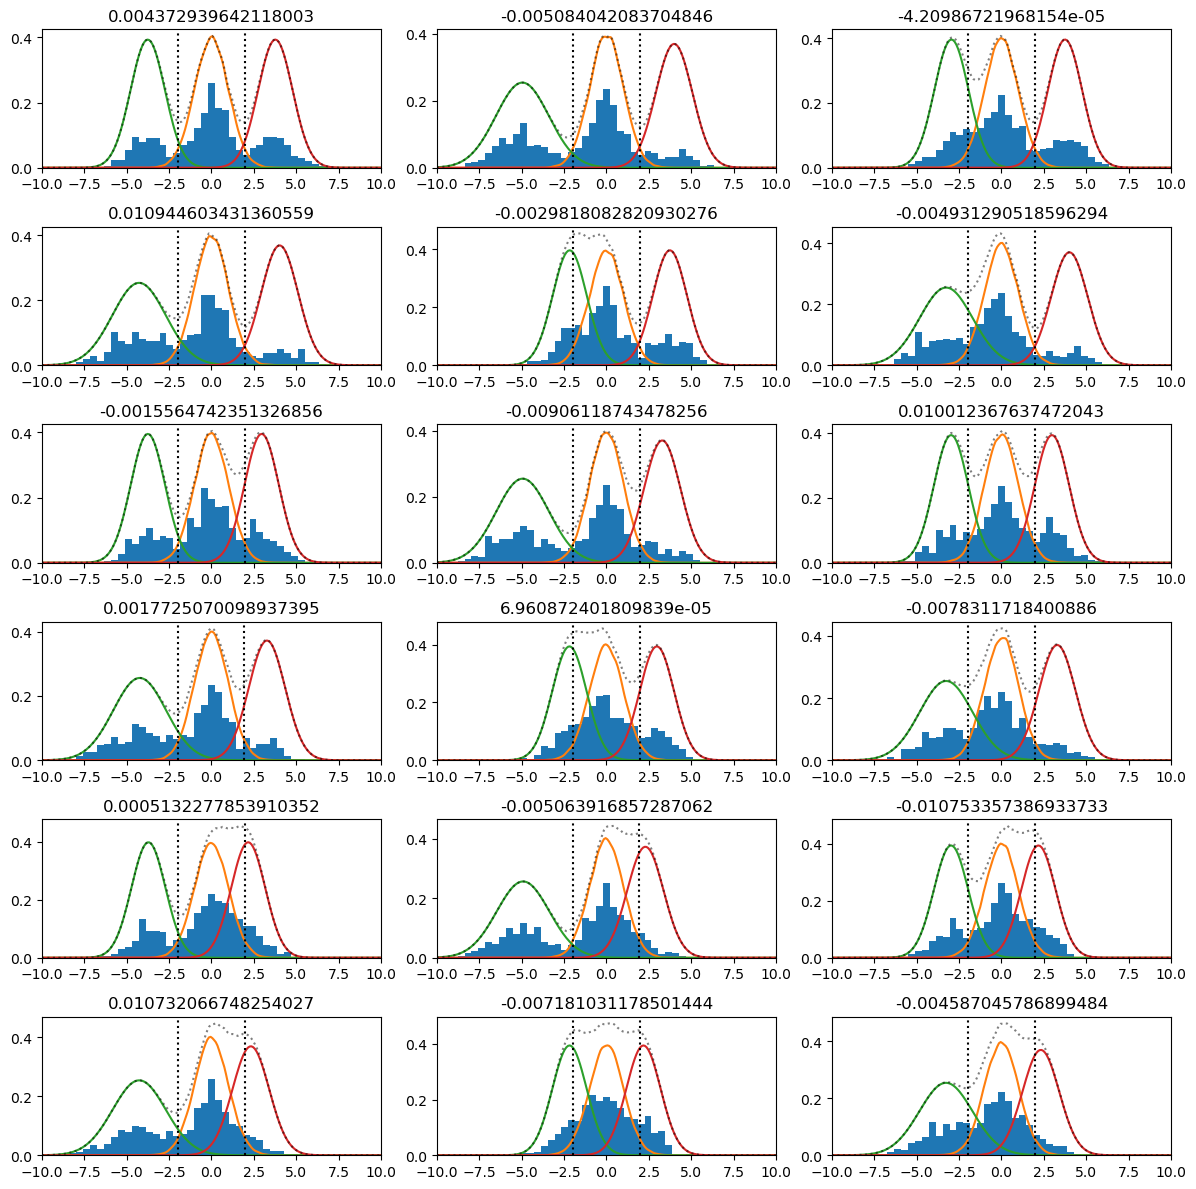

In [10]:
# now we can plot an analyte in standardized space
analyte = 'Hb'

nr = 6
nc = 3
x = np.linspace(-10, 10, 200)
plt.figure(figsize=(12, 12))
idx = np.where(params.Analyte==analyte)[0]
for c,i in enumerate(idx):
    
    plt.subplot(nr, nc, c+1)
    
    plt.hist((sample_data[i]-ref_mean[i])/ref_std[i], np.linspace(-10, 10, 50), density=True)
    
    plt.plot(x, ref_pdf[i])
    left_pdf = scipy.stats.norm(
        (params.iloc[i]['left_mu']-ref_mean[i])/ref_std[i],
        params.iloc[i]['left_sigma']/ref_std[i]
    ).pdf(x)
    plt.plot(x, left_pdf)
    right_pdf = scipy.stats.norm(
        (params.iloc[i]['right_mu']-ref_mean[i])/ref_std[i],
        params.iloc[i]['right_sigma']/ref_std[i]
    ).pdf(x)
    plt.plot(x, right_pdf)
    plt.plot(x, ref_pdf[i]+left_pdf+right_pdf, c='k', linestyle=':', alpha=0.5)
    plt.axvline((params.iloc[i]['GT_LRL']-ref_mean[i])/ref_std[i], c='k', linestyle=':')
    plt.axvline((params.iloc[i]['GT_URL']-ref_mean[i])/ref_std[i], c='k', linestyle=':')
    plt.axvline(ref_zero[i], c='r', linestyle=':')
#     plt.xlim([ref_zero[i]-1, 11])
    plt.xlim([-10, 10])
    plt.title(ref_skew[i])
    
plt.tight_layout();
plt.show();


In [11]:
# collect all pathological statistcs, plus skew
left_mean_abs = np.abs([i[0] for i in p_mean])[np.argsort(ref_skew)]
right_mean = np.array([i[1] for i in p_mean])[np.argsort(ref_skew)]
left_std = np.array([i[0] for i in p_std])[np.argsort(ref_skew)]
right_std = np.array([i[1] for i in p_std])[np.argsort(ref_skew)]
bg_min_abs = np.abs([i[0] for i in bg_range])[np.argsort(ref_skew)]
bg_max = np.array([i[1] for i in bg_range])[np.argsort(ref_skew)]
left_edge_abs = np.abs(ref_zero)[np.argsort(ref_skew)]
ref_skew_sorted = np.sort(np.array(ref_skew))


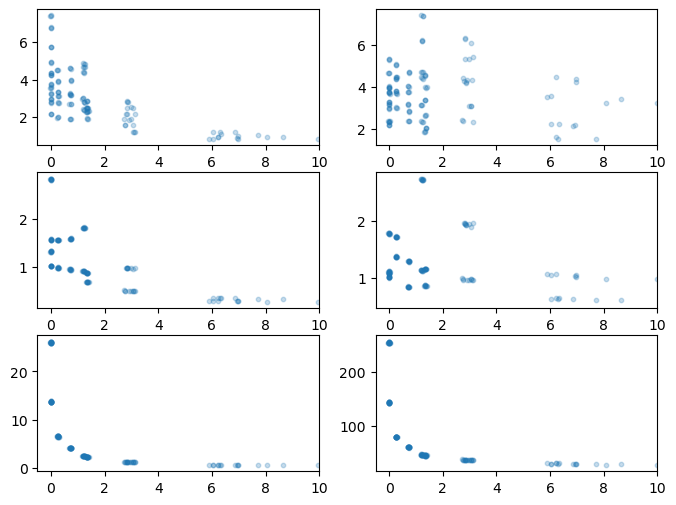

In [12]:
plt.figure(figsize=(8, 6))
plt.subplot(3,2,1)
plt.scatter(ref_skew_sorted, left_mean_abs, alpha=0.25, s=10);
plt.xlim([-0.5, 10]);
plt.subplot(3,2,2)
plt.scatter(ref_skew_sorted, right_mean, alpha=0.25, s=10);
plt.xlim([-0.5, 10]);
plt.subplot(3,2,3)
plt.scatter(ref_skew_sorted, left_std, alpha=0.25, s=10);
plt.xlim([-0.5, 10]);
plt.subplot(3,2,4)
plt.scatter(ref_skew_sorted, right_std, alpha=0.25, s=10);
plt.xlim([-0.5, 10]);

plt.subplot(3,2,5)
plt.scatter(ref_skew_sorted, left_edge_abs, alpha=0.25, s=10);
plt.xlim([-0.5, 10]);
plt.subplot(3,2,6)
plt.scatter(ref_skew_sorted, bg_max, alpha=0.25, s=10);
plt.xlim([-0.5, 10]);



/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


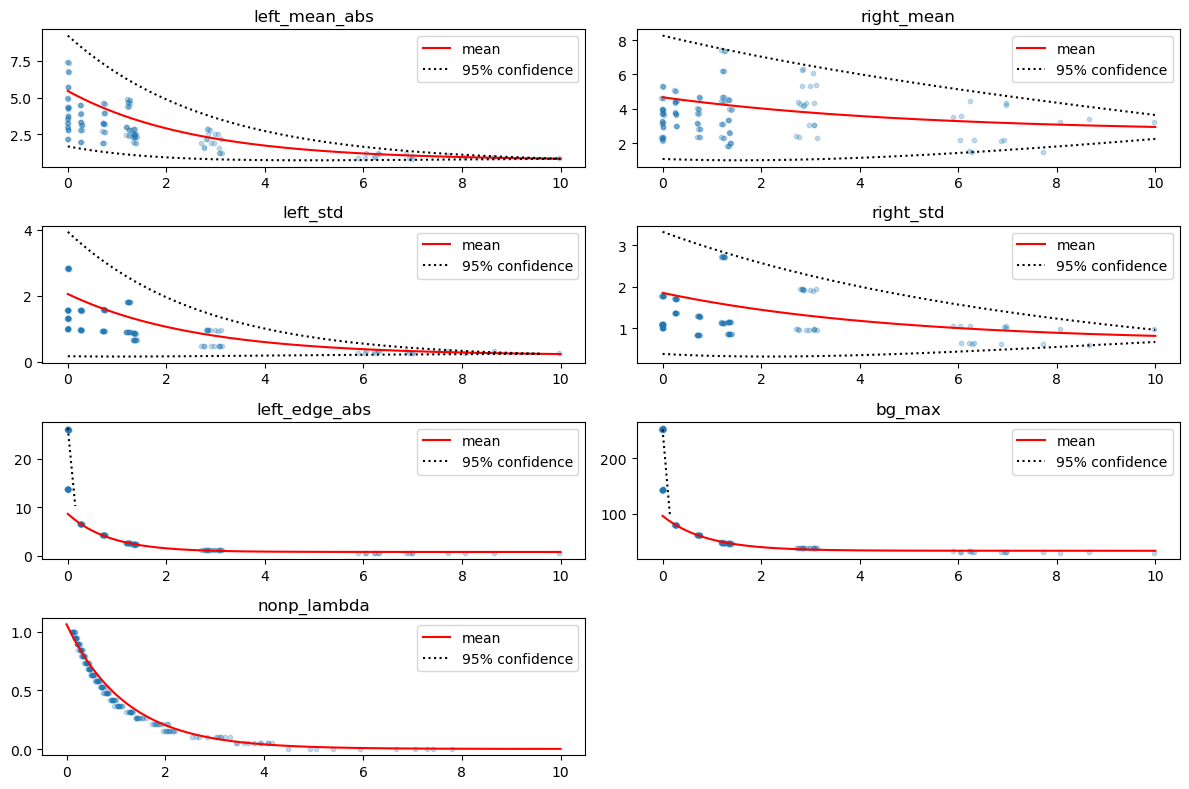

In [13]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import norm, halfnorm
import matplotlib.pyplot as plt

# define the exponential decay and linear fit functions
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

def linear(x, a, b):
    return a * x + b

# class for m
class RIbenchModeler:
    def __init__(self, bin_shift, max_skew):
        self.bin_shift = bin_shift
        self.max_skew = max_skew
        self.bin_starts = np.arange(0, max_skew, bin_shift)
        self.min_std = 0.1
        self.min_mean_abs = 0
        self.fits = {}
        self.data = {}

    def fit(self, plot=False):
        '''
        Model the parameters of RIbench mixtures
        as functions of the reference component skew
        
        '''
        
        bin_starts = self.bin_starts

        x_data = ref_skew_sorted[ref_skew_sorted<=max_skew]
        self.data['x_data'] = x_data
        
        # left pathological means - both parameters modeled with exp. decay
        # we use binning to have uniform influence of fitting across x range
        # fit mean
        bin_width = 3
        self.data['left_mean_abs'] = left_mean_abs[ref_skew_sorted<=max_skew]
        y_data = self.data['left_mean_abs']
        means = np.array([np.mean(y_data[(x_data>=i) & (x_data<(i+bin_width))]) for i in bin_starts])
        popm, _ = opt.curve_fit(exp_decay, bin_starts+bin_width/2, means, nan_policy='omit')
        # fit std
        stds = np.array([np.std(y_data[(x_data>=i) & (x_data<(i+bin_width))]) for i in bin_starts])
        popv, _ = opt.curve_fit(exp_decay, bin_starts+bin_width/2, stds, nan_policy='omit')
        # store the fits
        self.fits['left_mean_abs'] = {
            'mean': {'func': exp_decay, 'params': popm},
            'std': {'func': exp_decay, 'params': popv}
        }
        
        # right pathological means
        bin_width = 3
        self.data['right_mean'] = right_mean[ref_skew_sorted<=max_skew]
        y_data = self.data['right_mean']
        means = np.array([np.mean(y_data[(x_data>=i) & (x_data<(i+bin_width))]) for i in bin_starts])
        popm, _ = opt.curve_fit(exp_decay, bin_starts+bin_width/2, means, nan_policy='omit')
        stds = np.array([np.std(y_data[(x_data>=i) & (x_data<(i+bin_width))]) for i in bin_starts])
        popv, _ = opt.curve_fit(linear, bin_starts+bin_width/2, stds, nan_policy='omit')
        self.fits['right_mean'] = {
            'mean': {'func': exp_decay, 'params': popm},
            'std': {'func': linear, 'params': popv}
        }
        
        # left stds
        bin_width = 3
        self.data['left_std'] = left_std[ref_skew_sorted<=max_skew]
        y_data = self.data['left_std']
        means = np.array([np.mean(y_data[(x_data>=i) & (x_data<(i+bin_width))]) for i in bin_starts])
        popm, _ = opt.curve_fit(exp_decay, bin_starts+bin_width/2, means, nan_policy='omit')
        stds = np.array([np.std(y_data[(x_data>=i) & (x_data<(i+bin_width))]) for i in bin_starts])
        popv, _ = opt.curve_fit(exp_decay, bin_starts+bin_width/2, stds, nan_policy='omit')
        self.fits['left_std'] = {
            'mean': {'func': exp_decay, 'params': popm},
            'std': {'func': exp_decay, 'params': popv}
        }
        
        # right stds
        bin_width = 3
        self.data['right_std'] = right_std[ref_skew_sorted<=max_skew]
        y_data = self.data['right_std']
        means = np.array([np.mean(y_data[(x_data>=i) & (x_data<(i+bin_width))]) for i in bin_starts])
        popm, _ = opt.curve_fit(exp_decay, bin_starts+bin_width/2, means, nan_policy='omit')
        stds = np.array([np.std(y_data[(x_data>=i) & (x_data<(i+bin_width))]) for i in bin_starts])
        popv, _ = opt.curve_fit(exp_decay, bin_starts+bin_width/2, stds, nan_policy='omit')
        self.fits['right_std'] = {
            'mean': {'func': exp_decay, 'params': popm},
            'std': {'func': exp_decay, 'params': popv}
        }
        
        # left_edge (same as background minimum)
        self.data['left_edge_abs'] = left_edge_abs[ref_skew_sorted<=max_skew]
        y_data = self.data['left_edge_abs']
        popm, _ = opt.curve_fit(exp_decay, x_data[x_data>=0.1], y_data[x_data>=0.1])
        self.fits['left_edge_abs'] = {
            'mean': {'func': exp_decay, 'params': popm},
            'std': {'func': linear, 'params': [-50, 9]}
        }
        
        # bg_max
        self.data['bg_max'] = bg_max[ref_skew_sorted<=max_skew]
        y_data = self.data['bg_max']
        popm, _ = opt.curve_fit(exp_decay, x_data[x_data>=0.1], y_data[x_data>=0.1])
        self.fits['bg_max'] = {
            'mean': {'func': exp_decay, 'params': popm},
            'std': {'func': linear, 'params': [-50*10, 80]}
        }
    
        # nonp lambda
        temp_lambda = []
        temp_skew = []
        repeats = 10
        self.data['nonp_lambda'] = {'x':[], 'y':[]}
        for i in np.linspace(1, 0, 20): # loop inv_boxcox lambdas
            for repeat in range(repeats): # repeat for each one
                temp_data = np.random.normal(2.571, 1.104715, 10000) # take data
                temp_data = scipy.special.inv_boxcox(temp_data[temp_data>=0], i) # transform 
                temp_data -= temp_data.mean() # standardize
                temp_data /= temp_data.std()
                temp_lambda.append(i) # record lambda and skew
                temp_skew.append(scipy.stats.skew(temp_data))
                self.data['nonp_lambda']['x'].append(temp_skew[-1])
                self.data['nonp_lambda']['y'].append(temp_lambda[-1])
        temp_lambda = np.array(temp_lambda)
        temp_skew = np.array(temp_skew)
        bin_width = 1
        means = np.array([np.mean(temp_lambda[(temp_skew>=i) & (temp_skew<(i+bin_width))]) for i in bin_starts])
        popm, _ = opt.curve_fit(exp_decay, bin_starts+bin_width/2, means, nan_policy='omit')
        self.fits['nonp_lambda'] = {
            'mean': {'func': exp_decay, 'params': popm},
            'std': {'func': linear, 'params': [0, 0]}
        }
        del temp_lambda, temp_skew, repeats
        
        if plot:
            plt.figure(figsize=(12, 8))
            plt.subplot(4,2,1)
            self.plot_fit('left_mean_abs')
            plt.subplot(4,2,2)
            self.plot_fit('right_mean')
            plt.subplot(4,2,3)
            self.plot_fit('left_std')
            plt.subplot(4,2,4)
            self.plot_fit('right_std')
            plt.subplot(4,2,5)
            self.plot_fit('left_edge_abs')
            plt.subplot(4,2,6)
            self.plot_fit('bg_max')
            plt.subplot(4,2,7)
            self.plot_fit('nonp_lambda')
            plt.tight_layout()
            

    def plot_fit(self, param_name):
        '''
        Plot fitted parameter functions
        '''
        x = np.linspace(0, 10, 200)
        if param_name!='nonp_lambda':
            plt.scatter(self.data['x_data'], self.data[param_name], alpha=0.25, s=10)
        else:
            plt.scatter(self.data[param_name]['x'], self.data[param_name]['y'], alpha=0.25, s=10)
        plt.plot(x, np.maximum(self.min_mean_abs, self.fits[param_name]['mean']['func'](x, *self.fits[param_name]['mean']['params'])), c='r', label='mean')
        if param_name not in ['left_edge_abs', 'bg_max']:
            plt.plot(
                x, 
                [
                    np.maximum(self.min_std, norm(
                        self.fits[param_name]['mean']['func'](i, *self.fits[param_name]['mean']['params']), 
                        self.fits[param_name]['std']['func'](i, *self.fits[param_name]['std']['params'])).ppf(0.025)) \
                    for i in x
                ], c='k', linestyle=':'
            )
        plt.plot(
            x, 
            [
                np.maximum(self.min_std, norm(
                    self.fits[param_name]['mean']['func'](i, *self.fits[param_name]['mean']['params']), 
                    self.fits[param_name]['std']['func'](i, *self.fits[param_name]['std']['params'])).ppf(0.975)) \
                for i in x
            ], c='k', linestyle=':', label='95% confidence'
        ) 
        plt.title(param_name)
        plt.legend();
        

    def generate(self, ref_skew):
        '''
        Generate pathological component parameters based on the fits and a reference skew
        '''
        params = {}
        for key in self.fits.keys(): # loop over mixture parameters
            if key!='nonp_lambda': # for lambda, don't use variance
                if key not in ['left_edge_abs', 'bg_max']:
                    
                    # sample using gaussian
                    model = norm( # create gaussian for sampling current parameter
                        loc=self.fits[key]['mean']['func'](ref_skew, *self.fits[key]['mean']['params']), 
                        scale=np.maximum(0, self.fits[key]['std']['func'](ref_skew, *self.fits[key]['std']['params']))
                    )
                    params[key] = model.rvs(1)
                    
#                     # sample using uniform with central 99%
#                     if self.fits[key]['std']['func'](ref_skew, *self.fits[key]['std']['params'])<=0:
#                         params[key] = self.fits[key]['mean']['func'](ref_skew, *self.fits[key]['mean']['params'])                    
#                     else:
#                         params[key] = np.random.uniform(
#                             norm(
#                                 loc=self.fits[key]['mean']['func'](ref_skew, *self.fits[key]['mean']['params']), 
#                                 scale=np.maximum(0, self.fits[key]['std']['func'](ref_skew, *self.fits[key]['std']['params']))
#                             ).ppf(0.025),
#                             norm(
#                                 loc=self.fits[key]['mean']['func'](ref_skew, *self.fits[key]['mean']['params']), 
#                                 scale=np.maximum(0, self.fits[key]['std']['func'](ref_skew, *self.fits[key]['std']['params']))
#                             ).ppf(0.975)
#                         )
                        
                else:
                    
                    # a half-distribution is used for left edge and bg max; only varies with skew~0
                    model = halfnorm( 
                        loc=self.fits[key]['mean']['func'](ref_skew, *self.fits[key]['mean']['params']), 
                        scale=np.maximum(0, self.fits[key]['std']['func'](ref_skew, *self.fits[key]['std']['params']))
                    )
                    params[key] = model.rvs(1)

#                     if self.fits[key]['std']['func'](ref_skew, *self.fits[key]['std']['params'])<=0:
#                         params[key] = self.fits[key]['mean']['func'](ref_skew, *self.fits[key]['mean']['params'])
#                     else:
#                         params[key] = np.random.uniform(
#                             self.fits[key]['mean']['func'](ref_skew, *self.fits[key]['mean']['params']), 
#                             norm(
#                                 loc=self.fits[key]['mean']['func'](ref_skew, *self.fits[key]['mean']['params']), 
#                                 scale=np.maximum(0, self.fits[key]['std']['func'](ref_skew, *self.fits[key]['std']['params']))
#                             ).ppf(0.975)
#                         )
                        
                if 'mean' in key: # put limits
                    params[key] = np.maximum(self.min_mean_abs, params[key])
                if 'std' in key:
                    params[key] = np.maximum(self.min_std, params[key])
            else: # for lambda there is no variance
                params[key] = self.fits[key]['mean']['func'](ref_skew, *self.fits[key]['mean']['params'])
        # make sure left component is not too low based on the left edge
        params['left_mean_abs'] = -np.maximum(-params['left_edge_abs']-params['left_std'], -params['left_mean_abs'])
        return params

# Example usage:
bin_shift = 1  # skew bin shift
max_skew = 10

# Create an instance of DataModeler
modeler = RIbenchModeler(bin_shift, max_skew)
                                        
# Fit the model
modeler.fit(plot=True)



In [14]:
def plot_mixture_pdf(params, legend=True, target=False):
    
    x_range = np.linspace(-10, 10, 200)
    
    ref_norm = norm(loc=2.571, scale=1.104715)
    ref_data = ref_norm.rvs(10000)
    ref_data = scipy.special.inv_boxcox(ref_data[ref_data>=0], params['nonp_lambda'])
    ref_mean = ref_data.mean()
    ref_std = ref_data.std()
    ref_data -= ref_mean
    ref_data /= ref_std
    ref_kde = scipy.stats.gaussian_kde(ref_data) # get KDE for plotting
    ref_pdf = ref_kde(x_range)*0.6
    plt.plot(x_range, ref_pdf, label='reference')
    
    if target:
        plt.axvline((scipy.special.inv_boxcox(ref_norm.ppf(0.025), params['nonp_lambda'])-ref_mean)/ref_std, c='k', linestyle=':')
        plt.axvline((scipy.special.inv_boxcox(ref_norm.ppf(0.975), params['nonp_lambda'])-ref_mean)/ref_std, c='k', linestyle=':')
    
    left_norm = norm(loc=-params['left_means_abs'], scale=params['left_stds'])
    left_pdf = left_norm.pdf(x_range)*0.2
    plt.plot(x_range, left_pdf, label='left component')
    right_norm = norm(loc=params['right_means'], scale=params['right_stds'])
    right_pdf = right_norm.pdf(x_range)*0.2
    plt.plot(x_range, right_pdf, label='right component')
    plt.plot(x_range, ref_pdf+left_pdf+right_pdf, c='k', linestyle=':', label='mixture pdf')
    
    plt.axvline(-params['left_edges_abs'], c='r', linestyle=':')
    
    if legend:
        plt.legend()
    
# nr, nc = 4, 3
# plt.figure(figsize=(12, 8))
# for i in range(nr*nc):
#     plt.subplot(nr, nc, i+1)
#     if i==0:
#         legend=True
#     else:
#         legend=False
#     sample_params = modeler.generate(ref_skew=0.66)    
#     plot_mixture_pdf(sample_params, legend=legend)
#     plt.xlim([-sample_params['left_edges_abs'], 10])
#     plt.yticks([])
# plt.tight_layout()


In [15]:
def quantize_data(data, step):
    """
    Quantize the input data by rounding each float to the nearest multiple of the given step.

    :param data: List or array of floats to be quantized.
    :param step: The step size for quantization (e.g., 0.2).
    :return: List of quantized floats.
    """
    quantized_data = [round(x / step) * step for x in data]
    return quantized_data

def create_mixture_sample(
    params, 
    sample_size = 1000,
    p_frac = 0.4,
    p_ratio = 0.5,
    quantize_step = 0
):
    '''
    Sample from a generated mixture
    
    '''
    # get sizes
    bg_fraction = 0.001
    ref_size = int(sample_size*(1-p_frac-bg_fraction))
    p_sizes = int(sample_size*p_frac)
    p_sizes = [int(p_sizes*p_ratio), int(p_sizes*(1-p_ratio))]
    
    # reference component
    
    # NOTE: couldn't the reference resampling here mess up the target RIs?
    #       well, there should barely be any part of the distributions <0
    
    ref_model = norm(loc=2.571, scale=1.104715)
    ref_comp = ref_model.rvs(ref_size)
    ref_comp = ref_comp[ref_comp>=0]
    if len(ref_comp) < ref_size: # if there are not enough positive values, oversample then subsample>=0 (following RIbench)
        ref_comp = ref_model.rvs(ref_size*3)
        ref_comp = ref_comp[ref_comp>=0]
        ref_comp = ref_comp[np.random.choice(len(ref_comp), ref_size, replace=False)]
    ref_comp = scipy.special.inv_boxcox(ref_comp, params['nonp_lambda']) # transform
        
    # target params
    target = []
    for i in [0.01, 0.025, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.975, 0.99]:
        target.append((scipy.special.inv_boxcox(ref_model.ppf(i), params['nonp_lambda'])-ref_comp.mean())/ref_comp.std())
    target = np.array(target)
    
    ref_comp -= ref_comp.mean() # standardize
    ref_comp /= ref_comp.std()
    
    # left path comp
    left_comp = norm(loc=-params['left_mean_abs'], scale=params['left_std']).rvs(p_sizes[0])
    left_comp = left_comp[left_comp>=-params['left_edge_abs']]
    if len(left_comp) < p_sizes[0]:
        left_comp = norm(loc=-params['left_mean_abs'], scale=params['left_std']).rvs(p_sizes[0]*3)
        while len(left_comp[left_comp>=-params['left_edge_abs']])<p_sizes[0]/10:
            left_comp = norm(loc=-params['left_mean_abs'], scale=params['left_std']).rvs(p_sizes[0]*3)
        left_comp = left_comp[left_comp>=-params['left_edge_abs']]
        if len(left_comp) < p_sizes[0]:
            left_comp = left_comp[np.random.choice(len(left_comp), p_sizes[0], replace=True)]
        else:
            left_comp = left_comp[np.random.choice(len(left_comp), p_sizes[0], replace=False)]

    # right path comp
    right_comp = norm(loc=params['right_mean'], scale=params['right_std']).rvs(p_sizes[1])
    if len(right_comp) < p_sizes[1]:
        right_comp = norm(loc=-params['right_mean_abs'], scale=params['right_std']).rvs(p_sizes[1]*3)
        right_comp = right_comp[right_comp>=-params['left_edge_abs']]
        right_comp = right_comp[np.random.choice(len(right_comp), p_sizes[1], replace=0)]

    # background noise
    bg_noise = np.random.uniform(params['left_edge_abs'], params['bg_max'], int(sample_size*bg_fraction))
    
    mixture = np.hstack([ref_comp, left_comp, right_comp, bg_noise]);
    
    if quantize_step:
        mixture = quantize_data(mixture, quantize_step)
        
    comp_sizes = np.array([len(ref_comp), len(left_comp), len(right_comp)])
        
    return mixture, target, comp_sizes


In [16]:
# check below for plotting example mixtures


In [23]:
# generate training data

training_x = []
training_y = []
training_sizes = []
n_points = 3000

for i in range(n_points):
    
    if i%100==0:
        print(i)
        
    sample_params = modeler.generate(ref_skew = 0)
    
    sample_mixture, sample_target, comp_sizes = create_mixture_sample(
        sample_params, 
        sample_size = np.random.choice([500, 1000, 5000, 10000]),
        p_frac = 0.3,
        p_ratio = 0.5,
        quantize_step = np.random.choice([0, 0.05, 0.1, 0.2])
    )

    training_x.append(sample_mixture)
    training_y.append(sample_target)
    training_sizes.append(comp_sizes)
    

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [24]:
with open('./generalize_test/x_train.pkl', 'wb') as f:
    pickle.dump(training_x, f)
with open('./generalize_test/y_train.pkl', 'wb') as f:
    pickle.dump(training_y, f)
with open('./generalize_test/sizes_train.pkl', 'wb') as f:
    pickle.dump(training_sizes, f)


In [25]:
del training_x, training_y, training_sizes


In [26]:
# generate training data

training_x = []
training_y = []
training_sizes = []
n_points = 1000

for i in range(n_points):
    
    if i%100==0:
        print(i)
        
    sample_params = modeler.generate(ref_skew = 0)
    
    sample_mixture, sample_target, comp_sizes = create_mixture_sample(
        sample_params, 
        sample_size = np.random.choice([500, 1000, 5000, 10000]),
        p_frac = 0.3,
        p_ratio = np.linspace(0, 1, n_points)[i],
        quantize_step = np.random.choice([0, 0.05, 0.1, 0.2])
    )

    training_x.append(sample_mixture)
    training_y.append(sample_target)
    training_sizes.append(comp_sizes)
    

0
100
200
300
400
500
600
700
800
900


In [27]:
with open('./generalize_test/x_test.pkl', 'wb') as f:
    pickle.dump(training_x, f)
with open('./generalize_test/y_test.pkl', 'wb') as f:
    pickle.dump(training_y, f)
with open('./generalize_test/sizes_test.pkl', 'wb') as f:
    pickle.dump(training_sizes, f)


In [28]:
del training_x, training_y, training_sizes
